In [1]:
import numpy as np # We need to import the Numpy library as it's optimized to numerical operations
import pandas as pd # The pandas dataframe is a python data structure that helps construct rows and columns for data sets
import matplotlib.pyplot as plt # This library is responsible for creating the necessary plots and graphs
import tensorflow # This is a python framework with which different models can be easily implemented

In [2]:
data = pd.read_csv('coin_Bitcoin.csv') # Here we are simply using pandas to import the csv file containing the BTC data

In [3]:
data.head() # Taking a quick look at the first 5 rows of the data

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [5]:
# Here we specify the columns we need and set the date as index
required_data = data[['Date','High','Low','Open','Close']]
required_data.set_index("Date",drop=True,inplace=True)
required_data.head()

,High,Low,Open,Close
Date,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000


In [6]:
# The log returns is optimized for stationarity and so we create an extra column for it
required_data['% Returns'] = required_data.Close.pct_change() # we find the percentage change using the pct_change() method
required_data['Log returns'] = np.log(1 + required_data['% Returns']) # from the percentage returns we can easily compute log returns
required_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,High,Low,Open,Close,% Returns,Log returns
Date,,,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,NaN,NaN
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,-0.038328,-0.039082
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,-0.158345,-0.172385
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,-0.100692,-0.106130
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,-0.070906,-0.073545


In [7]:
required_data.dropna(inplace=True) # We drop all null/NaN values so that we do not get a value error


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


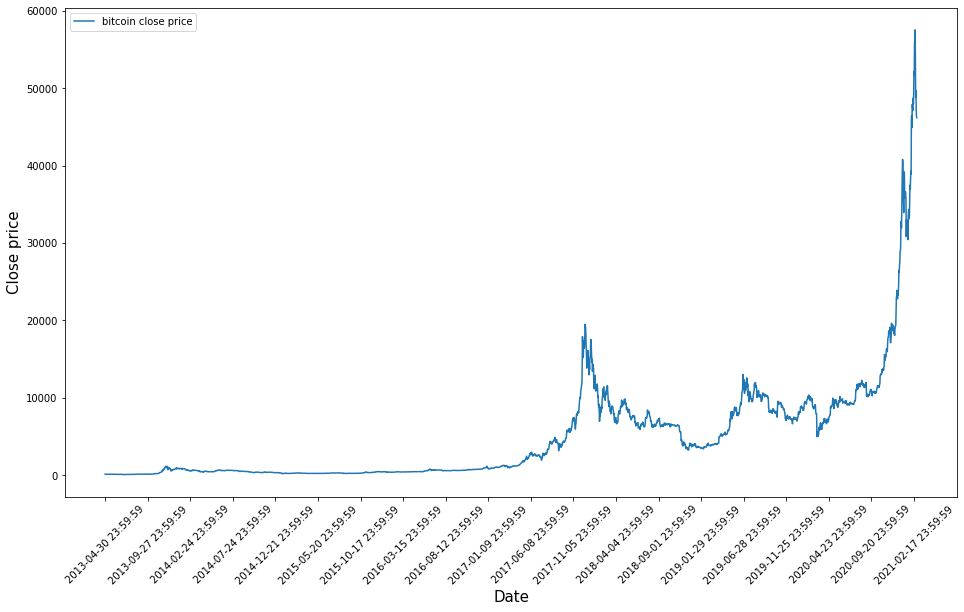

In [8]:
# We make a plot of the closing price over the given timeframe to have a peek at the price behaviour prior to modeling 
plt.figure(figsize=(16,9))
plt.plot(range(required_data.shape[0]),required_data['Close'],label='bitcoin close price')
plt.xticks(range(0,required_data.shape[0],150),required_data.index[::150],rotation=45)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close price',fontsize=15)
plt.legend(loc='best')
plt.show()

In [9]:
# For the training inputs, we will utilize two parameters, the closing price and the log returns
x = required_data[['Close','Log returns']].values
x

array([[ 1.39000000e+02, -3.90823063e-02],
       [ 1.16989998e+02, -1.72385490e-01],
       [ 1.05209999e+02, -1.06130099e-01],
       ...,
       [ 4.70938530e+04, -5.39697542e-02],
       [ 4.63397601e+04, -1.61421417e-02],
       [ 4.61884513e+04, -3.27054722e-03]])

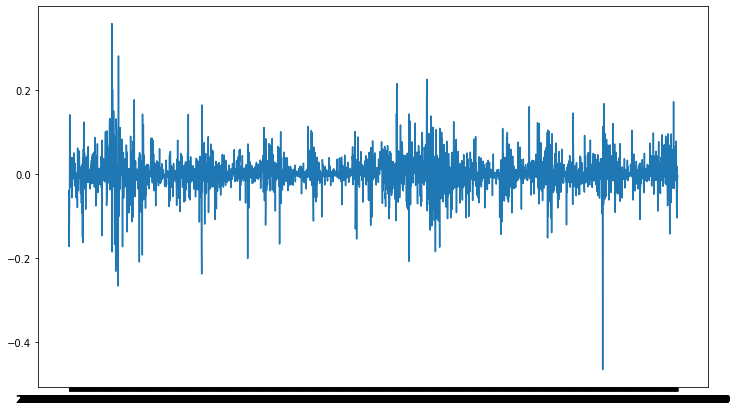

In [10]:
# The log returns is a stationary parameter and we can observe its mean reversion from the plot 
plt.figure(figsize=(12,7))
plt.plot(required_data['Log returns'])

In [11]:
x = required_data[['Close','Log returns']].values

In [13]:
# Normalization: This helps to scale the data so that it lies within the range 0 to 1, this helps especially
#                 when the data has a high standard deviation

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [14]:
scaler = MinMaxScaler(feature_range=(0,1)).fit(x) # we pass the relevant data to the MinMax scaler
x_scaled = scaler.transform(x)
x_scaled[0:5]

array([[1.22789530e-03, 5.17705755e-01],
       [8.44922917e-04, 3.55572157e-01],
       [6.39951823e-04, 4.36157067e-01],
       [5.10148400e-04, 4.75789397e-01],
       [7.66797291e-04, 7.36176265e-01]])

In [15]:
y = [x[0] for x in x_scaled] # For the training outputs, we specify only the closing price as that is what we want to predict, right?
y[:5]

[0.0012278952992176289,
 0.0008449229166509456,
 0.0006399518234535607,
 0.0005101484001897834,
 0.0007667972913573161]

In [16]:
split_point = int(len(x_scaled)*0.8) # Using 80% of the data as training set, we mark out a split point at the 80% mark
print(split_point)

2288


In [17]:
# Creating the training and testing sequence
x_train = x_scaled[:split_point]
x_test = x_scaled[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

In [19]:
# Here we are simply verifying that the datasets have the right dimensions
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

Labeling the model

In [21]:
time_step = 3 # the time step for the LSTM model
xtrain = []
ytrain = []
xtest = []
ytest = []

for i in range(time_step,len(x_train)):
  xtrain.append(x_train[i-time_step:i,:x_train.shape[1]]) # we want to use the last 3 days' data to predict the next day
  ytrain.append(y_train[i])
for i in range(time_step, len(y_test)):
  xtest.append(x_test[i-time_step:i,:x_test.shape[1]])
  ytest.append(y_test[i])

In [22]:
print(xtrain[0])
print(ytrain[0])
print(x_train[:5])

[[0.0012279  0.51770576]
 [0.00084492 0.35557216]
 [0.00063995 0.43615707]]
0.0005101484001897834
[[1.22789530e-03 5.17705755e-01]
 [8.44922917e-04 3.55572157e-01]
 [6.39951823e-04 4.36157067e-01]
 [5.10148400e-04 4.75789397e-01]
 [7.66797291e-04 7.36176265e-01]]


In [23]:
# LSTM architecture
# Number of observations
# time steps
# number of Features per step 

# We'll need to add a temporal dimension

 LSTM architecture
- Number of observations
- time steps
- number of Features per step 


In [26]:
np.array(xtrain).shape

(2285, 3, 2)

In [28]:
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain = np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]))

xtest, ytest = np.array(xtest), np.array(ytest)
xtest = np.reshape(xtest,(xtest.shape[0],xtest.shape[1],xtest.shape[2]))

In [30]:
print(xtrain.shape)
print(ytrain.shape)
print('----')
print(xtest.shape)
print(ytest.shape)

(2285, 3, 2)
(2285,)
----
(570, 3, 2)
(570,)


In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [34]:
# the input shape comprises the time step and the number of obsevations
model = Sequential()
model.add(LSTM(4,input_shape=(xtrain.shape[1],xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='adam')
model.fit(
    xtrain,ytrain,epochs=100,validation_data=(xtest,ytest),batch_size=16,verbose=1
)

Epoch 1/100
143/143 [==============================] - 19s 9ms/step - loss: 0.0127 - val_loss: 0.0506
Epoch 2/100
143/143 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0327
Epoch 3/100
143/143 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0110
Epoch 4/100
143/143 [==============================] - 0s 3ms/step - loss: 4.1077e-04 - val_loss: 0.0023
Epoch 5/100
143/143 [==============================] - 0s 3ms/step - loss: 5.5838e-05 - val_loss: 0.0017
Epoch 6/100
143/143 [==============================] - 0s 3ms/step - loss: 4.9957e-05 - val_loss: 0.0017
Epoch 7/100
143/143 [==============================] - 0s 3ms/step - loss: 4.0589e-05 - val_loss: 0.0020
Epoch 8/100
143/143 [==============================] - 0s 3ms/step - loss: 4.0109e-05 - val_loss: 0.0020
Epoch 9/100
143/143 [==============================] - 0s 3ms/step - loss: 3.5285e-05 - val_loss: 0.0021
Epoch 10/100
143/143 [==============================] - 1s 3ms/ste

In [35]:
model.summary() # Summary of the model parameters

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Prediction phase
train_predict = model.predict(xtrain) 
test_predict = model.predict(xtest)

In [40]:
# Here we are concatenating with an array of zeros since we know that our scaler requires a 2D input
train_predict = np.c_[train_predict,np.zeros(train_predict.shape)]
test_predict = np.c_[test_predict,np.zeros(test_predict.shape)]

In [42]:
# to obtain the values on the right scale, we have to inverse transform the data
train_predict = scaler.inverse_transform(train_predict)
train_predict = [x[0] for x in train_predict]

test_predict = scaler.inverse_transform(test_predict)
test_predict = [x[0] for x in test_predict]

In [43]:
print(train_predict[:5])
print(test_predict[:5])

[128.9825366589186, 128.791668230779, 250.81547078082818, 145.12735086347638, 107.12783401435135]
[11970.829458753662, 11754.452530331122, 11848.608578931486, 11352.281297994365, 11475.612062204065]


In [44]:
from sklearn.metrics import mean_squared_error

In [46]:
train_score = mean_squared_error([x[0][0] for x in xtrain],train_predict, squared=False)
print('Train score: {}'.format(train_score))
test_score = mean_squared_error([x[0][0] for x in xtest],test_predict,squared=False)
print('Test score: {}'.format(test_score))

Train score: 4420.036011547039
Test score: 13957.621757708266


In [62]:
print(test_predict[:5])
#print(scaler.inverse_transform(y_test[:5]))


[11970.829458753662, 11754.452530331122, 11848.608578931486, 11352.281297994365, 11475.612062204065]


In [78]:
original_btc_price = [y[0] for y in x[split_point:]] # generating the original btc price sequence
original_btc_price[:5]

[11805.653725299999,
 11478.169346100001,
 11941.9683406,
 11966.407405,
 11862.936759999999]

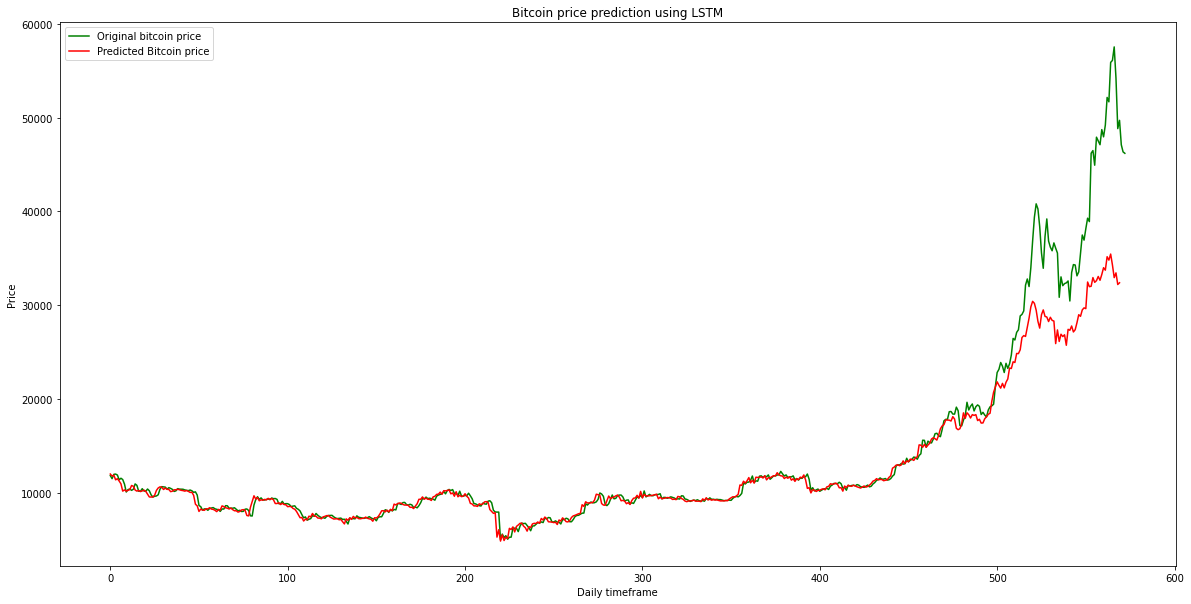

In [93]:
# We now try to visualize our prediction along with the original data in order to see how well it performed!
plt.figure(figsize=(20,10))
plt.plot(original_stock_price,color='green',label='Original bitcoin price')
plt.plot(test_predict,color='red',label='Predicted Bitcoin price')
plt.title('Bitcoin price prediction using LSTM')
plt.xlabel('Daily timeframe')
plt.ylabel('Price')
plt.legend()
plt.show()